Further analysis of butterfly data:

In [2]:
# import libraries
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(
    style="darkgrid",
    color_codes=True,
    palette='Dark2',
)

# import (personal) functions & variables
from funcs import import_pickled_data, which_cols, number_of_day_to_date, highlight_years
from vals import sheets
species, species_long, species_summed = import_pickled_data()

## Total count per species

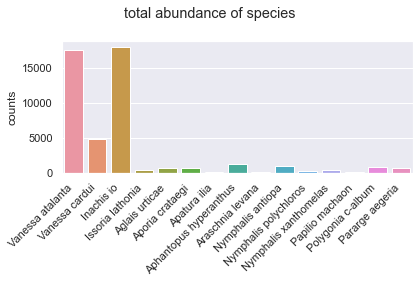

In [3]:
# compute total number of counts per species
total = np.zeros(len(sheets))
for i, s in enumerate(sheets):
    df = species[s]
    cols = which_cols(df)
    total[i] = df[cols].sum().sum()

# and plotting
fig, ax = plt.subplots()
sns.barplot(x=sheets, y=total)
plt.xticks(rotation=45, ha='right')
ax.set_ylabel('counts')
#ax.set(yscale='log')
fig.suptitle('total abundance of species')
fig.tight_layout()
fig.savefig('../figs/total-count_per_species.pdf')

## First and last day of sight

In [4]:
# compute total number of counts per year per species
total_year = dict()
years = np.arange(1982, 2020+1) # years as integers
for s in sheets:
    df = species_summed[s]
    dummy_counts = np.zeros(len(years))
    for i in range(len(dummy_counts)):
        dummy_counts[i] = df['count'][df['Year'] == years[i]].sum(min_count=1)
    total_year[s] = dummy_counts

In [5]:
# compute first and last day of appearance per species
def first_last_day(df):
    '''
    data frame must have a 'Year' column!
    '''
    years = np.arange(1982, 2020+1)
    first = np.zeros(len(years))
    last = np.zeros(len(years))
    for i in range(len(years)):
        try:
            # select first index with butterfly count greater than 0
            xfirst = df[(df['Year'] == years[i]) & (df['count'] >= 1)].index[0]
            # and last index
            xlast = df[(df['Year'] == years[i]) & (df['count'] >= 1)].index[-1]
        except:
            print(f'No counts in {years[i]}.')
            first[i], last[i] = np.nan, np.nan
        else:
            first[i], last[i] = (df['datetime'].iloc[[xfirst, xlast]] - pd.Timestamp(f'1/1/{years[i]}')).values.astype('timedelta64[D]')
    return first, last

No counts in 1987.
No counts in 1988.
No counts in 1989.
No counts in 1990.
No counts in 1991.
No counts in 1996.
No counts in 1982.
No counts in 1984.
No counts in 1986.
No counts in 1987.
No counts in 1988.
No counts in 1989.
No counts in 1990.
No counts in 1991.
No counts in 1992.
No counts in 1993.
No counts in 1997.
No counts in 1999.
No counts in 2008.
No counts in 1988.
No counts in 1989.
No counts in 1991.
No counts in 2019.
No counts in 1982.
No counts in 1983.
No counts in 1984.
No counts in 1985.
No counts in 1986.
No counts in 1987.
No counts in 1988.
No counts in 1989.
No counts in 1990.
No counts in 1991.
No counts in 1992.
No counts in 1993.
No counts in 1994.
No counts in 1995.
No counts in 1996.
No counts in 1997.
No counts in 1998.
No counts in 2019.
No counts in 1988.
No counts in 1989.
No counts in 1990.
No counts in 1991.
No counts in 1992.
No counts in 1983.
No counts in 1984.
No counts in 1985.
No counts in 1986.
No counts in 1987.
No counts in 1988.
No counts in

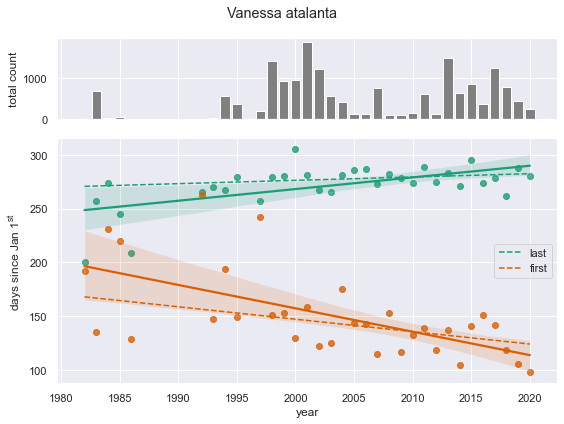

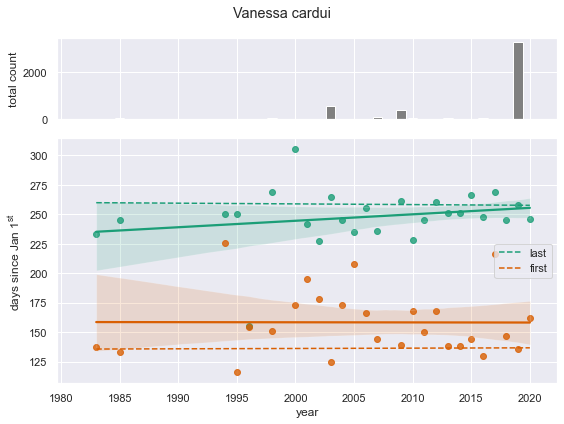

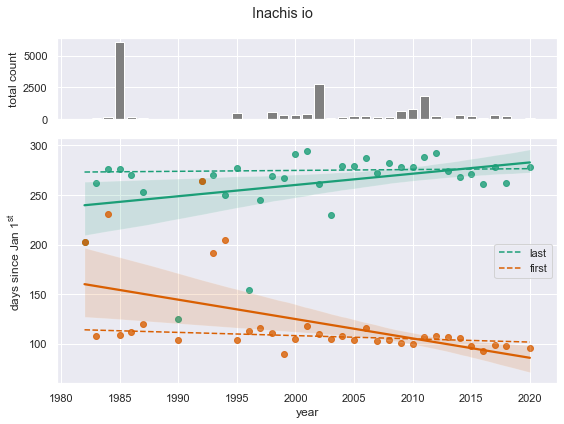

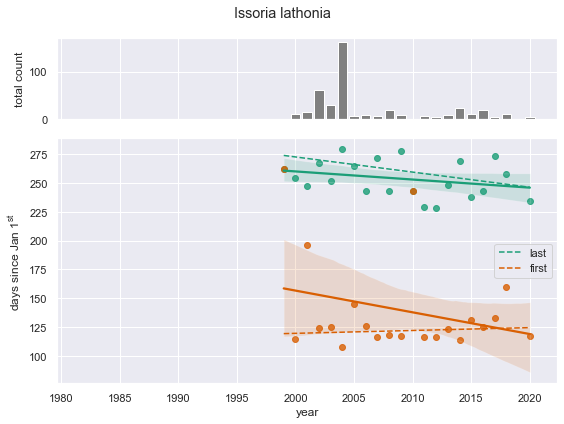

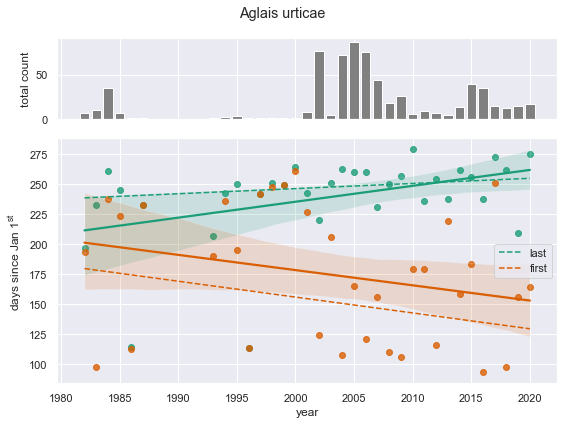

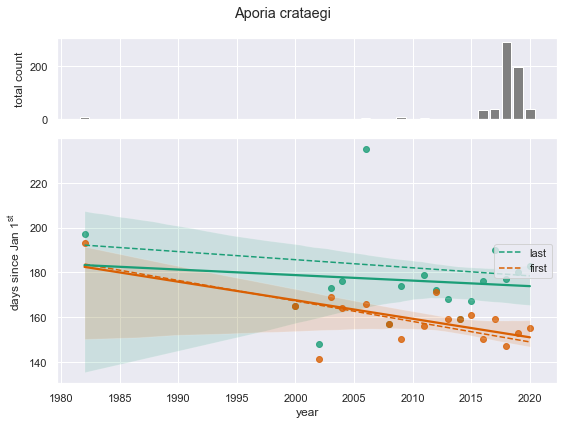

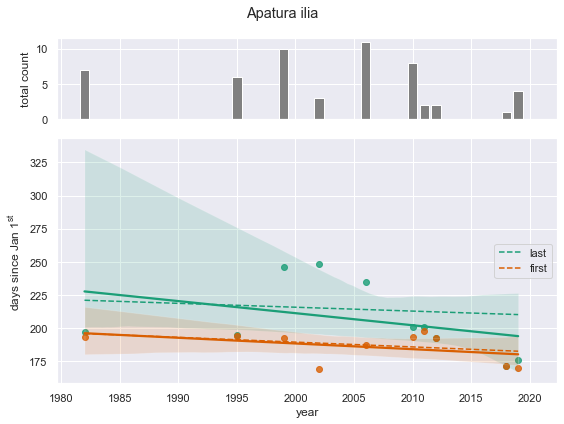

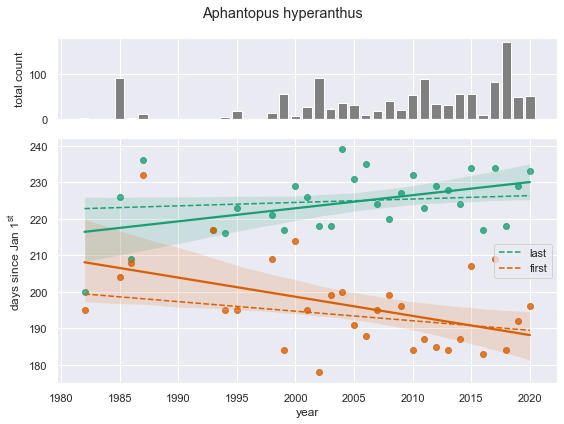

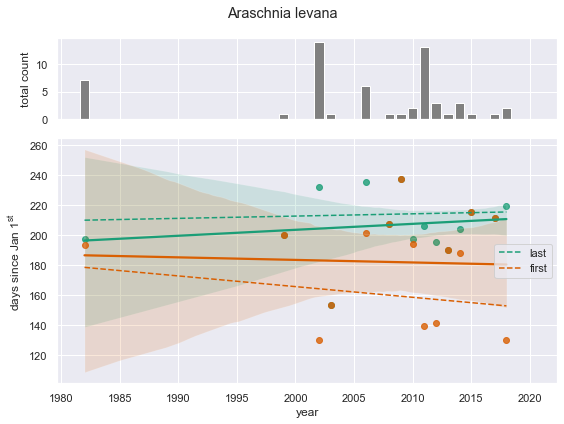

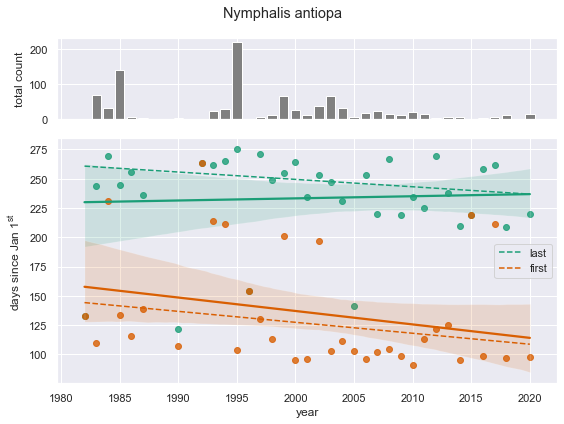

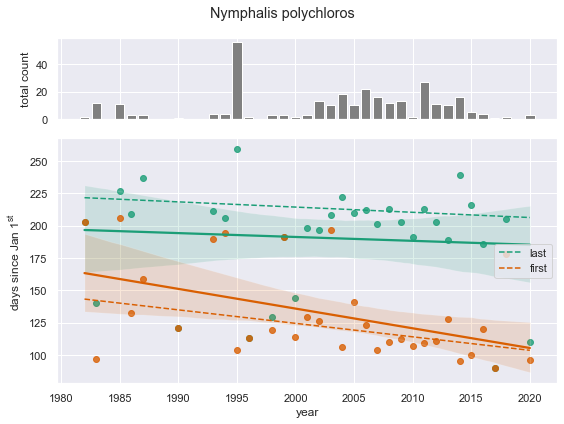

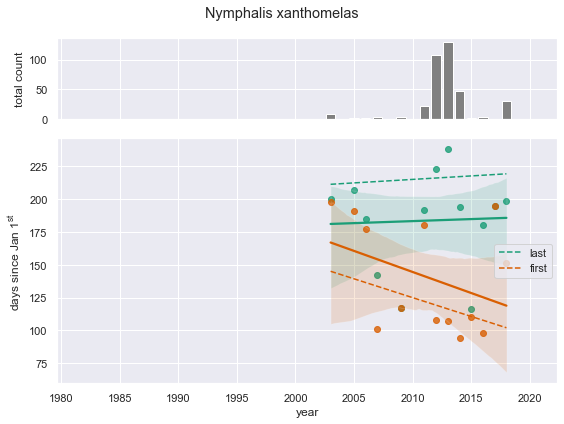

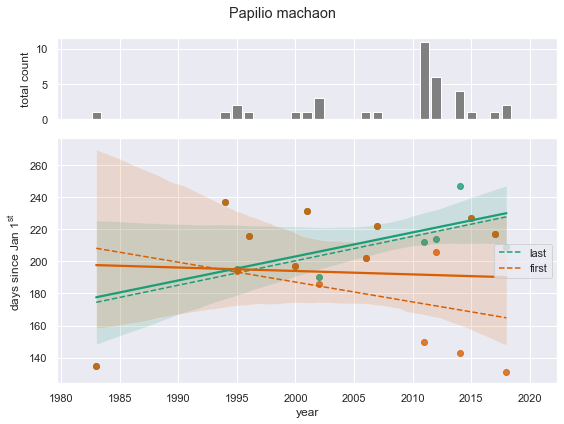

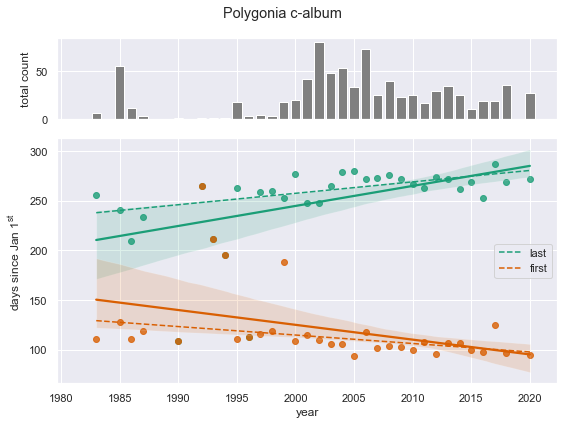

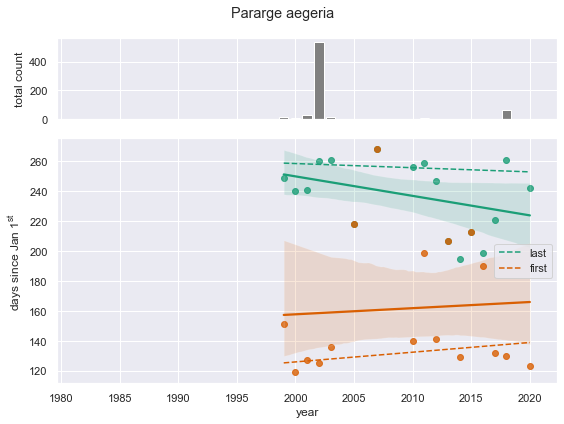

In [18]:
# compute first and last day of sight throughout entire time series per species
# NOTE: by now, seaborn can't perform WEIGHTED linear regression, compare: https://github.com/mwaskom/seaborn/issues/2163
#       however, in other libraries (e.g., numpy, scipy, scikit-learn) weights can be added!
from sklearn.linear_model import LinearRegression
import matplotlib.cm as cm
c = np.arange(0,1,1/7)
years_dt = pd.date_range(start='1/1/1982',end='1/1/2020', freq='YS').values.astype('datetime64[D]') # years as datetime object
first, last = dict(), dict()

for s in sheets:
    df = species_summed[s]
    first[s], last[s] = first_last_day(df)
    
    # WEIGHTED LINEAR REGRESSION
    # define index to sort out nan's
    index = np.logical_not(np.isnan(first[s]))
    X_years = years[index].reshape(-1,1)
    # define weights as total count per year
    wghts = total_year[s][index]
    # first day of sight
    yf = first[s][index]
    regr_first = LinearRegression()
    regr_first.fit(X=X_years, y=yf, sample_weight=wghts)
    # last day of sight
    yl = last[s][index]
    regr_last = LinearRegression()
    regr_last.fit(X=X_years, y=yl, sample_weight=wghts)
    
    # and plotting...
    f, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [1, 3]}, figsize=(8, 6))
    axs[0].bar(years, total_year[s], color='grey')
    #axs[0].set_yscale('log')
    axs[0].set_ylabel('total count')

    axs[1].plot(X_years, regr_last.predict(X_years), color=cm.Dark2(c[0]), ls='--')
    axs[1].plot(X_years, regr_first.predict(X_years), color=cm.Dark2(c[1]), ls='--')
    # legend refers to the previously plotted functions (!)
    axs[1].legend(labels=['last', 'first'], loc='center right') 
    sns.regplot(x=years, y=last[s], ax=axs[1])
    sns.regplot(x=years, y=first[s], ax=axs[1])
    axs[1].set_ylabel(r'days since Jan 1$^\mathregular{st}$')
    axs[1].set_xlabel('year')
    f.suptitle(f'{s}')
    f.tight_layout()
    f.savefig(f'../figs/species_kaliningrad_first-last-day/{s}.pdf')

In [7]:
number_of_day_to_date(100)

Day number: 100
Resolved date: 09-04-2020


## Comparing v. cardui & v. atalanta

Weekly resolution

In [8]:
# transform insect counts to weekly data / change temporal resolution
species_weekly = dict()
cols = ['datetime', 'year', 'count']
# loop over species
for s in sheets:
    df = species_summed[s]
    # create empty data frame to hold weekly counts
    df_temp = pd.DataFrame(columns=cols)
    # loop over years
    for y in years:
        # extract data from single year
        df_y = df[df.Year == y]
        count_temp = []
        year_temp = []
        datetime_temp = []
        # create index [0, 7, 14, ...] to sum up counts of 7 consecutive days,
        # append weekly count, year and datetime of first (!) day to list
        for i in range(0, len(df_y.index-7), 7):
            count_temp.append(df_y['count'].iloc[i:i+7].sum(min_count=1))
            year_temp.append(df_y['Year'].iloc[i])
            datetime_temp.append(df_y['datetime'].iloc[i])
        # update output data frame
        zipped = list(zip(datetime_temp,year_temp,count_temp))
        df_temp = df_temp.append(pd.DataFrame(zipped, columns=cols), ignore_index=True)
    # add data frame holding weekly counts to species dict
    species_weekly[s] = df_temp

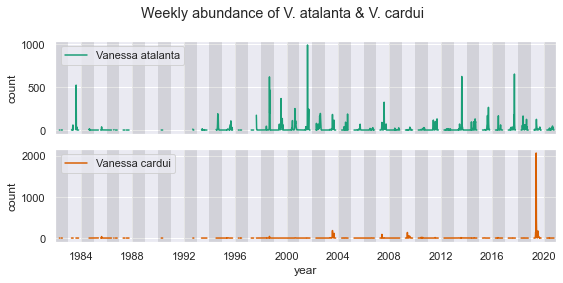

In [9]:
# plot time series of weekly count of atalanta & cardui (unedited and cropped x-axis)
import itertools
# set palette 
palette = itertools.cycle(sns.color_palette())

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,4))
butterflies = ['Vanessa atalanta', 'Vanessa cardui']
for i, s in enumerate(butterflies):
    # color
    c = next(palette)
    df = species_weekly[s]
    axs[i].plot(df['datetime'], df['count'], c=c)
    axs[i].legend(labels=[s], loc='upper left')
    #axs[i].set_yscale('log')
    highlight_years(axs[i])
    axs[i].set_ylabel('count')
    # cropping x-axis to 1982-2020
    axs[i].set_xlim(left=pd.to_datetime('1982-01-01'),right=pd.to_datetime('2020-12-31')) # OPTIONAL!
    #axs[i].set_ylim(bottom=0, top=400)
axs[1].set_xlabel('year')
fig.suptitle('Weekly abundance of V. atalanta & V. cardui')
fig.tight_layout()
fig.savefig('../figs/atalanta-vs-cardui/time-evol-weekly_atalanta-vs-cardui.pdf')

Yearly resolution

In [10]:
# CREATE BAR PLOT OF YEARLY ABUNDANCE OF V. ATALANTA & V. CARDUI
'''
seaborn    : doesn't sum up values belonging to same bar automatically, but rather computes 
             average & its error;
             requires data in "long"-format;
             adds, by default, label to x-axis for every bar
pandas     : requires proper data format;
matplotlib : everything's possible, but fairly low-level;

'''
# compute yearly abundance
dic = species_weekly
va_vc_ = dic[butterflies[0]].merge(
    right=dic[butterflies[1]],
    on=['datetime', 'year'],
    suffixes=('_va', '_vc')
).drop(labels='datetime', axis=1)
#va_vc_['year'] = pd.to_datetime(va_vc_['year'], format='%Y')
va_vc_ = va_vc_.groupby(['year']).sum(min_count=1)
va_vc_

,count_va,count_vc
year,,
1982,3.0,0.0
1983,681.0,4.0
1984,29.0,0.0
1985,53.0,46.0
1986,8.0,0.0
1987,0.0,0.0
1988,NaN,NaN
1989,NaN,NaN
1990,0.0,0.0


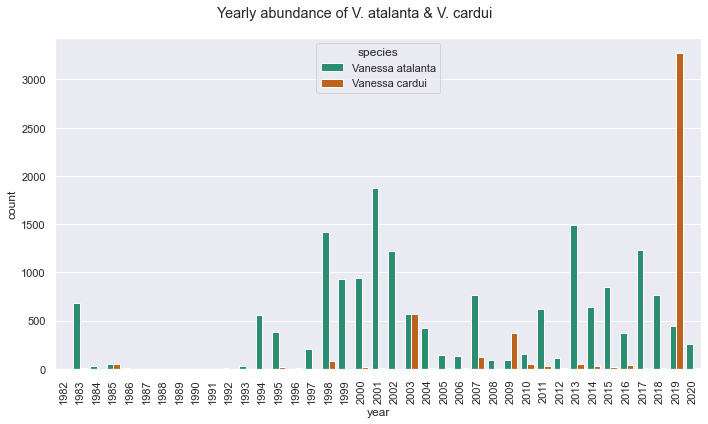

In [11]:
# SEABORN!
df = va_vc_.reset_index().melt(
    id_vars=['year'],
    value_vars=['count_va', 'count_vc'],
    var_name='species',
    value_name='count'
)
fig, ax = plt.subplots(figsize=(10,6))
g = sns.barplot(data=df, x='year', y='count', hue='species', ax=ax)
ax.set_xticklabels([str(year) for year in range(1982, 2021, 1)], rotation=90)
#ticks = ax.get_xticks()
#ax.set_xticks(ticks[::2])
#fig.autofmt_xdate()

# replace labels of legend
# https://stackoverflow.com/questions/45201514/how-to-edit-a-seaborn-legend-title-and-labels-for-figure-level-functions
for t, l in zip(g.legend_.texts, butterflies):
    t.set_text(l)

fig.suptitle('Yearly abundance of V. atalanta & V. cardui')
fig.tight_layout()
fig.savefig('../figs/atalanta-vs-cardui/time-evol-yearly_atalanta-vs-cardui.pdf')

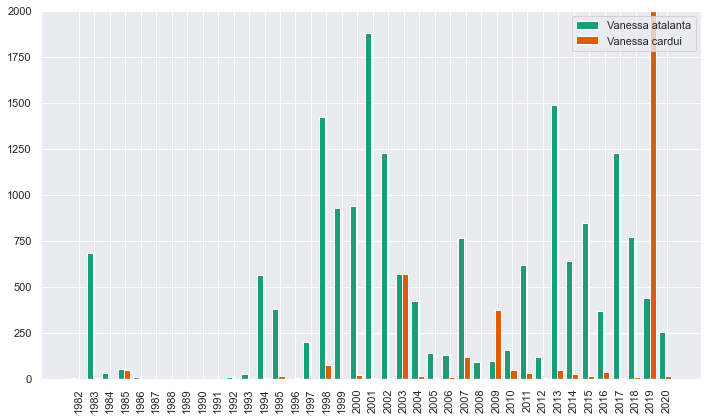

In [12]:
# MATPLOTLIB!
w = 0.4
df = va_vc_
x = df.index
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x-w/2, df['count_va'], width=w)
ax.bar(x+w/2, df['count_vc'], width=w)
ax.set_ylim(top=2000)
ax.set_xticks(x+w/4)
ax.set_xticklabels(x, rotation=90)
ax.legend(labels=butterflies)
fig.tight_layout()
# ...

## Total count per year

In [13]:
# compute yearly count for all species in single, long-format dataframe
df_species_yearly = pd.DataFrame()
for i, s in enumerate(sheets):
    df_temp = species_weekly[s]
    df_temp = df_temp.groupby('year', as_index=False).sum(min_count=1)
    df_temp['species'] = s
    df_species_yearly = pd.concat([df_species_yearly, df_temp])
df_species_yearly = df_species_yearly.reset_index(drop=True)
df_species_yearly

,year,count,species
0,1982,3.0,Vanessa atalanta
1,1983,681.0,Vanessa atalanta
2,1984,29.0,Vanessa atalanta
3,1985,53.0,Vanessa atalanta
4,1986,8.0,Vanessa atalanta
...,...,...,...
580,2016,3.0,Pararge aegeria
581,2017,5.0,Pararge aegeria
582,2018,68.0,Pararge aegeria
583,2019,0.0,Pararge aegeria


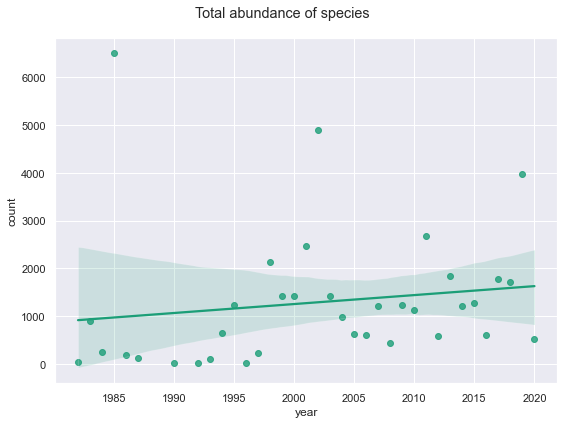

In [14]:
# visualize total count (of all species) per year
data = df_species_yearly.groupby('year', as_index=False).sum(min_count=1)
fig, ax = plt.subplots(figsize=(8,6))
sns.regplot(
    data=data, x='year', y='count', ax=ax,
)
fig.suptitle('Total abundance of species')
fig.tight_layout()
fig.savefig('../figs/total-count_per_year.pdf')

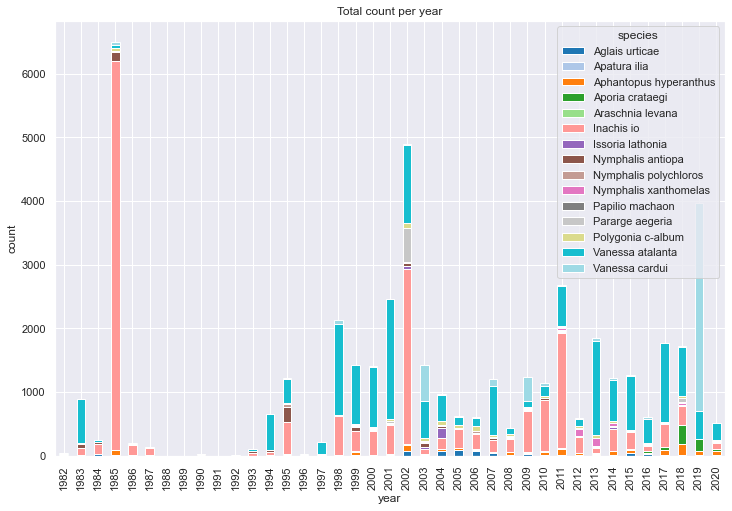

In [15]:
# plot total count per species per year
fig, ax = plt.subplots(figsize=(12,8))
data = df_species_yearly.pivot(index='year', columns='species', values='count')
data.plot.bar(stacked=True, ax=ax, ylabel='count', colormap='tab20', title='Total count per year')
fig.savefig('../figs/total-count_per_year_per_species.pdf')

## Residuals of first and last day of sight

In [16]:
# linear regression of total count of species
# https://stackoverflow.com/questions/35236836/weighted-linear-regression-with-scikit-learn
total_no_nans = df_species_yearly.groupby('year', as_index=False).sum(min_count=1).reset_index(drop=True).dropna()
total = df_species_yearly.groupby('year', as_index=False).sum(min_count=1)

from sklearn.linear_model import LinearRegression
skl_X = total_no_nans['year'].values.reshape(-1,1)
regr = LinearRegression()
regr.fit(
    X = skl_X,
    y = total_no_nans['count'].values,
)

LinearRegression()

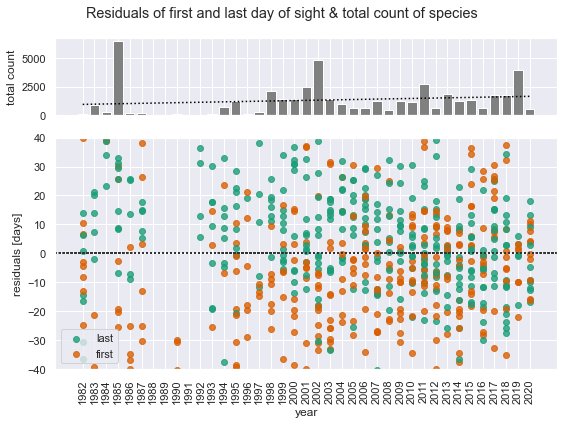

In [17]:
# plotting residuals of first and last day of sight 
import matplotlib.cm as cm
c = np.arange(0,1,1/7)
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [1, 3]}, figsize=(8, 6))

# total count of species as bar plot
axs[0].bar(years, total['count'], color='grey')
axs[0].plot(skl_X, regr.predict(skl_X), 'k:')
#axs[0].set_yscale('log')
axs[0].set_ylabel('total count')

# residuals of first and last day
for i, s in enumerate(sheets):
    if i == 0:
        sns.residplot(x=years, y=last[s], ax=axs[1], label='last', color=cm.Dark2(c[0]))
        sns.residplot(x=years, y=first[s], ax=axs[1], label='first', color=cm.Dark2(c[1]))
    else:
        sns.residplot(x=years, y=last[s], ax=axs[1], color=cm.Dark2(c[0]))
        sns.residplot(x=years, y=first[s], ax=axs[1], color=cm.Dark2(c[1]))
axs[1].set_xticks(years)
axs[1].set_xticklabels(years, rotation=90)
axs[1].set_ylim(top=40, bottom=-40)
axs[1].set_xlabel('year')
axs[1].set_ylabel('residuals [days]')
axs[1].legend()
fig.suptitle('Residuals of first and last day of sight & total count of species')
fig.tight_layout()
fig.savefig('../figs/species_kaliningrad_first-last-day/merged_residuals_y-axis-cropped.pdf')